## Check Device

In [1]:
import torch

device = (
    "cuda" if torch.cuda.is_available()
    # else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} as backend.")

if device == "cuda":
  !nvidia-smi

Using cpu as backend.


## Prepare Train and Validate Data

In [2]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader


def diodeClipper_dataset_load(N, Fs, num_up, num_down, r_begin, r_end):
    r_begin_str = f"{r_begin / 1000:.2f}k"
    r_end_str = f"{r_end / 1000:.2f}k"
    Fs_str = f"{Fs / 1000:.1f}k"

    data_path = ("./LTspice_data" +
                 f"/{num_up}u{num_down}d" + "/diode_clipper" + f"_{num_up}u{num_down}d" +
                 f"_{r_begin_str}" + f"_{r_end_str}" + f"_{Fs_str}"
                 )

    v_i_path = data_path + "_i.wav"
    v_o_path = data_path + "_o.wav"
    r_path = data_path + "_r.wav"

    v_i, _ = librosa.load(path=v_i_path, sr=None, mono=True)
    v_o, _ = librosa.load(path=v_o_path, sr=None, mono=True)
    r, _ = librosa.load(path=r_path, sr=None, mono=True)

    if len(v_i) != len(v_o):
        raise ValueError("The length of v_in and v_out are not same!")
    if len(v_i) != len(r):
        raise ValueError("The length of v_in and r are not same!")

    if N <= len(v_i):
        v_i = v_i[:N]
        v_o = v_o[:N]
        r   = r  [:N]
    else:
        raise ValueError("The N must be less or equal than the length of audio files.")

    Fs = np.ones_like(v_i) * Fs
    return np.stack((v_i, r, Fs), axis=-1), v_o


def get_diodeClipper_dataloader(N, Fs=None, num_up=1, num_down=1, r_begin: float = 10e3, r_end: float = 100e3, batch_size=16, split_ratio=0.8, shuffle=True, random_state=42, plot=False):
    if Fs is None:
        Fs = [48e3]

    x, y = [], []
    for Fs in Fs:
        v_i_r, v_o = diodeClipper_dataset_load(N, Fs, num_up, num_down, r_begin, r_end)
        x.extend(v_i_r)
        y.extend(v_o)
    x = np.array(x).squeeze()
    y = np.array(y).squeeze()

    num_batches = int(len(x) / batch_size)
    x_batched = x[:num_batches * batch_size].reshape(num_batches, batch_size, 3)
    y_batched = y[:num_batches * batch_size].reshape(num_batches, batch_size)

    x_train, x_valid, y_train, y_valid = train_test_split(
        x_batched, y_batched,
        train_size=split_ratio,
        shuffle=shuffle,
        random_state=random_state
    )

    train_ds = TensorDataset(
        torch.tensor(x_train, dtype=torch.float32).to(device),
        torch.tensor(y_train, dtype=torch.float32).to(device),
    )
    valid_ds = TensorDataset(
        torch.tensor(x_valid, dtype=torch.float32).to(device),
        torch.tensor(y_valid, dtype=torch.float32).to(device)
    )

    train_dl = DataLoader(train_ds, shuffle=True)
    valid_dl = DataLoader(valid_ds)

    if plot:
        v_in = x[:, 0]
        r_in = r_begin + (r_end - r_begin) * x[:, 1]
        v_out = y

        # fig_size = (18, 7)
        fig, ax1_1 = plt.subplots()

        line1, = ax1_1.plot(v_in, label='v_in')
        line2, = ax1_1.plot(v_out, label='v_out')
        ax1_1.set_ylim((-1.0, 1.0))
        ax1_1.set_ylabel('Voltage [V]')

        ax1_2 = ax1_1.twinx()
        line3, = ax1_2.plot(r_in, color='g', label='R_in')
        ax1_2.set_ylabel('Resistor [Ω]')
        ax1_2.set_ylim((r_begin, r_end))
        ax1_2.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

        lines = [line1, line2, line3]
        labels = [line.get_label() for line in lines]
        ax1_1.legend(lines, labels, loc='upper right')

        plt.show()

    return train_dl, valid_dl

## Neural Diode Clipper Model

In [3]:
import torch
from torch import nn
from typing import Callable

class DiodePair(nn.Module):
    def __init__(self, num_layers: int = 4, layer_size: int = 32, input_size: int = 2, output_size: int = 1, activation_fn: Callable = torch.relu):
        """
        A fully connected neural network module of WDF diode pair .

        Args:
            num_layers: The number of layers in the network.
            layer_size: The size of each layer.
            input_size: The size of the input layer. Defaults to 2.
            output_size: The size of the output layer. Defaults to 1.
            activation_fn: The activation function to use. Defaults to ReLU.
        """
        super().__init__()
        self.num_layers = num_layers
        self.layer_size = layer_size
        self.activation_fn = activation_fn

        self.input_layer = nn.Linear(input_size, layer_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(layer_size, layer_size) for _ in range(num_layers-1)])
        self.output_layer = nn.Linear(layer_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Args:
            x: The input tensor.

        Returns:
            The output tensor.
        """
        y = self.activation_fn(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            y = self.activation_fn(hidden_layer(y))
        y = self.output_layer(y)
        return y

class NDC(nn.Module):
    def __init__(self, Fs: float = 48e3, C1: float = 4.7e-9, Vs_R: float = 10e3, DP_path=None, num_layers: int = 4,
                 layer_size: int = 32):
        super().__init__()
        self.fs = torch.tensor(Fs, dtype=torch.float32, requires_grad=False)
        self.c1 = torch.tensor(C1, dtype=torch.float32, requires_grad=False)
        self.c1_r = 1 / (2 * self.c1 * self.fs)
        self.vs_r = torch.tensor(Vs_R, dtype=torch.float32, requires_grad=False)

        self.p1_r = None
        self.p1_g = None
        self.p1 = None
        self.update_parameter()

        self.dp = torch.load(DP_path) if DP_path else DiodePair(num_layers=num_layers, layer_size=layer_size)

    def set_states(self, vs_r, fs):
        self.vs_r = vs_r
        self.fs = fs
        self.update_parameter()

    def update_parameter(self):
        self.c1_r = 1 / (2 * self.c1 * self.fs)
        self.p1_r = torch.stack([(self.c1_r * self.vs_r) / (self.c1_r + self.vs_r), self.c1_r, self.vs_r])
        self.p1_g = torch.reciprocal(self.p1_r)
        self.p1 = (2.0 / torch.sum(self.p1_g)) * torch.ones(3, 1) @ self.p1_g.unsqueeze(0) - torch.eye(3)

    def forward(self, v_in, vs_r, fs):
        # waves initiate
        output = torch.zeros_like(v_in)
        c1_a = torch.tensor(0., dtype=torch.float32, requires_grad=False)
        p1_a = torch.zeros(3, requires_grad=False)

        for i in range(len(v_in)):
            self.set_states(vs_r[i], fs[i])

            # Forward Scan
            c1_b = c1_a
            vs_b = v_in[i]
            p1_a = torch.stack([p1_a[0], c1_b, vs_b])
            p1_b = self.p1 @ p1_a

            # Local Root Scattering
            dp_a = p1_b[0]
            dp_b = self.dp(torch.stack([dp_a, torch.log10(self.p1_r[0])])).squeeze(0)

            # Backward Scan
            p1_a = torch.stack([dp_b, p1_a[1], p1_a[2]])
            p1_b = self.p1 @ p1_a
            c1_a = p1_b[1]

            # Read Output
            output[i] = (dp_a + dp_b) / 2

        return output

## Fine-tune Diode Clipper Model

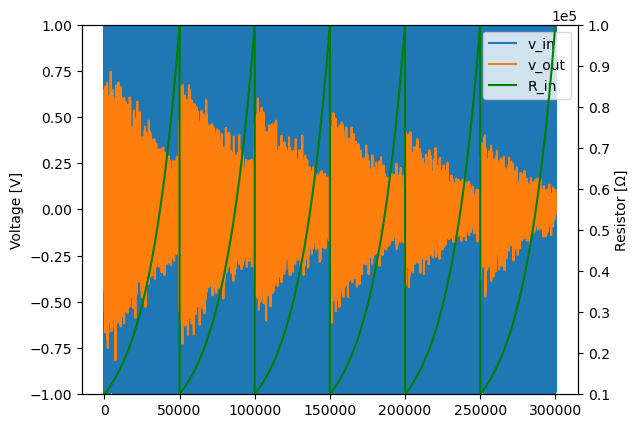

               [Train loss]    [Eval loss]     [Time left]
----------------------------------------------------------
Epoch     1		8.0107e-05		5.7223e-05		276.67 min
Epoch     2		8.0003e-05		6.2562e-05		258.84 min
Epoch     3		7.9597e-05		5.5807e-05		273.18 min
Epoch     4		7.9729e-05		6.2855e-05		261.99 min
Epoch     5		7.9344e-05		6.0980e-05		259.46 min
Epoch     6		7.9974e-05		5.5969e-05		262.13 min
Epoch     7		7.8895e-05		7.2279e-05		264.16 min
Epoch     8		7.9370e-05		5.6653e-05		256.49 min
Epoch     9		7.9711e-05		5.6269e-05		260.70 min
Epoch    10		7.9010e-05		5.6989e-05		260.73 min
Epoch    11		7.9397e-05		5.6228e-05		246.94 min
Epoch    12		7.9859e-05		5.5503e-05		246.64 min
Epoch    13		7.8566e-05		5.5480e-05		252.22 min
Epoch    14		7.9014e-05		5.5745e-05		253.76 min
Epoch    15		7.8607e-05		5.6645e-05		241.67 min
Epoch    16		7.9522e-05		5.5707e-05		240.32 min
Epoch    17		7.9134e-05		5.7596e-05		239.16 min
Epoch    18		7.8165e-05		5.8020e-05		237.94 min
Epoch    19		7.970

In [5]:
import time
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

num_up = 2
num_down = 3
dp_path = "pre_trained_models/2u3d/diode_pair_2u3d_1N4148_l_0.40k_3.00k_4x32_1.37e-06.pth"

r_begin = 10e3
r_end   = 100e3

N = 50000
Fs = [44.1e3, 48e3, 88.2e3, 96e3, 176.4e3, 192e3]

batch_size = 16
skip_size = 50
real_batch_size = batch_size + skip_size

epochs = 200

def train_epoch(model, train_dl, loss_func, skip_size, optimizer, train_mode=True):
    model.train()
    total_loss, total_samples = 0.0, 0
    for x, y in train_dl:
        x = x.squeeze()
        v_in = x[:, 0]
        r_in = r_begin + (r_end - r_begin) * x[:, 1]
        fs_in = x[:, 2]

        pred = model(v_in, r_in, fs_in)
        loss = loss_func(pred[skip_size:], y.squeeze()[skip_size:])
        total_loss += loss.item() * x.size(0)
        total_samples += x.size(0)

        if train_mode:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return total_loss / total_samples

def eval_model(model, valid_dl, loss_func, skip_size):
    model.eval()
    total_loss, total_samples = 0.0, 0
    with torch.no_grad():
        for x, y in valid_dl:
            x = x.squeeze()
            v_in = x[:, 0]
            r_in = r_begin + (r_end - r_begin) * x[:, 1]
            fs_in = x[:, 2]

            pred = model(v_in, r_in, fs_in)
            loss = loss_func(pred[skip_size:], y.squeeze()[skip_size:])
            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)
    return total_loss / total_samples

def save_model(model, path_root, loss):
    loss_str = f"{loss:.2e}"
    path_save = dp_path + f"_{loss_str}" + ".pth"
    torch.save(model, path_save)
    print(f"Save model to {path_save}")

def run_model(model, train_dl, valid_dl, epochs, loss_func, skip_size, optimizer, scheduler, train_mode):
    start_time = time.time()
    print("               [Train loss]    [Eval loss]     [Time left]")
    print("----------------------------------------------------------")
    train_losses, valid_losses = [], []

    for epoch in range(epochs):
        start_time_epoch = time.time()
        train_loss = train_epoch(model, train_dl, loss_func, skip_size, optimizer, train_mode)
        valid_loss = eval_model(model, valid_dl, loss_func, skip_size)
        scheduler.step(valid_loss)
        end_time_epoch = time.time()

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f"Epoch {epoch+1:>5d}\t\t{train_loss:>8.4e}\t\t{valid_loss:>8.4e}\t\t{(end_time_epoch-start_time_epoch)/60*(epochs-epoch-1):>.2f} min")

        # torch.save(model, f"checkpoint_epoch_{epoch}.pth")

    end_time = time.time()
    print(f"\nTime cost：{(end_time - start_time)/60:>.2f} min")

    return train_losses, valid_losses


model = NDC(DP_path=dp_path).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-7)
scheduler = ReduceLROnPlateau(optimizer, factor=0.50, verbose=True)
train_dl, valid_dl = get_diodeClipper_dataloader(N, Fs, num_up, num_down, r_begin, r_end, batch_size=real_batch_size, plot=True)

train_losses, valid_losses = run_model(model, train_dl, valid_dl, epochs, loss_func, skip_size, optimizer, scheduler, train_mode=True)

In [6]:
torch.save(model, "pre_trained_models/2u3d/diode_pair_2u3d_1N4148_l_0.40k_3.00k_4x32_6.00e-05_f_5.60e-05.pth")

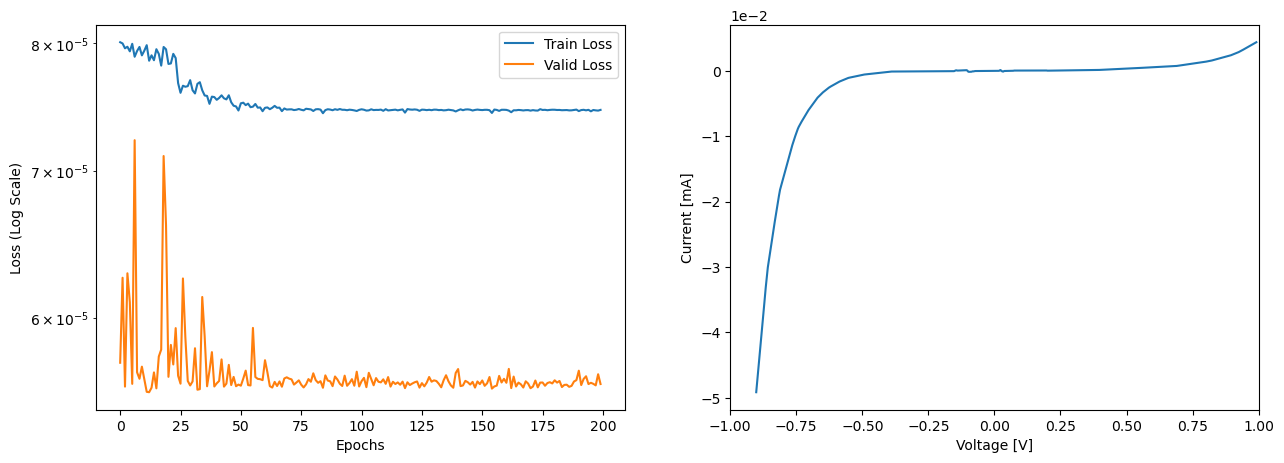

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(valid_losses, label='Valid Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss (Log Scale)')
ax1.set_yscale('log')
ax1.legend()

with torch.no_grad():
    a = torch.linspace(-1, 1, 1000)

    r = 2000
    r_log = torch.ones_like(a) * torch.log10(torch.tensor(r))

    b = model.dp(torch.stack([a, r_log], dim=1))
    a = a.detach().numpy().reshape(-1, 1)
    b = b.detach().numpy()
    v = (a + b) / 2
    i = (a - b) / (2*r)

ax2.plot(v, i*1e3)
ax2.set_xlabel('Voltage [V]')
ax2.set_ylabel('Current [mA]')
ax2.set_xlim(-1, 1)
# ax2.set_ylim(-1e-2, 1e-2)
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

Fs: 96000.0


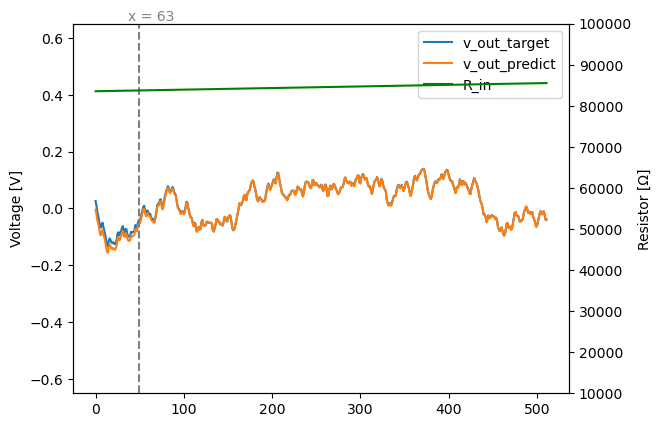

Fs: 176400.0


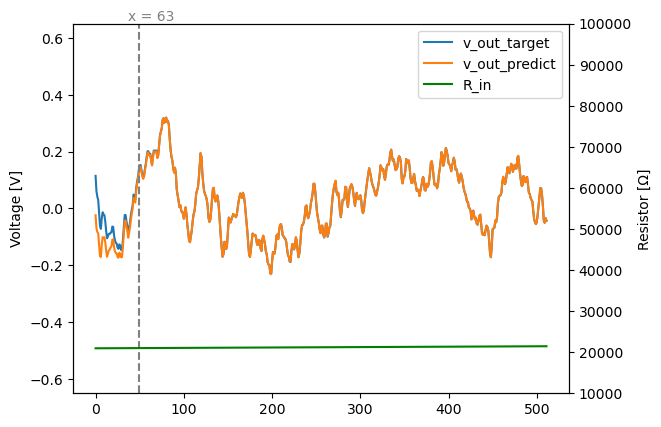

Fs: 44100.0


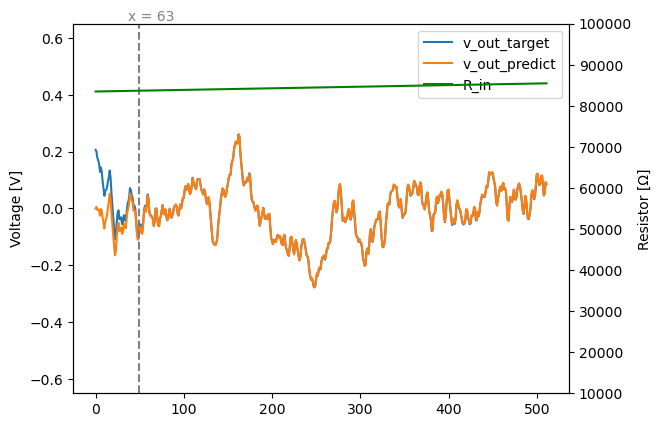

Fs: 176400.0


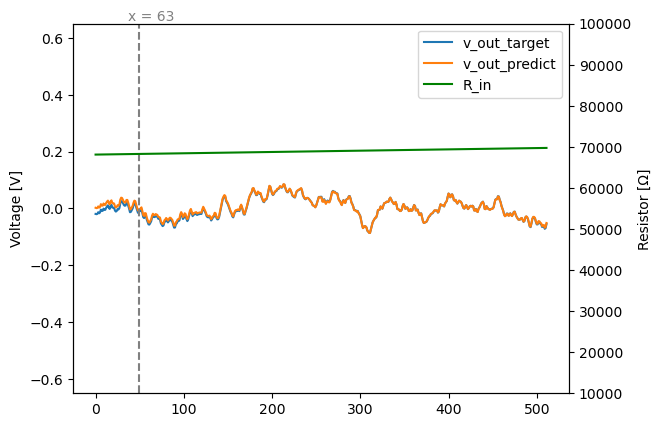

Fs: 192000.0


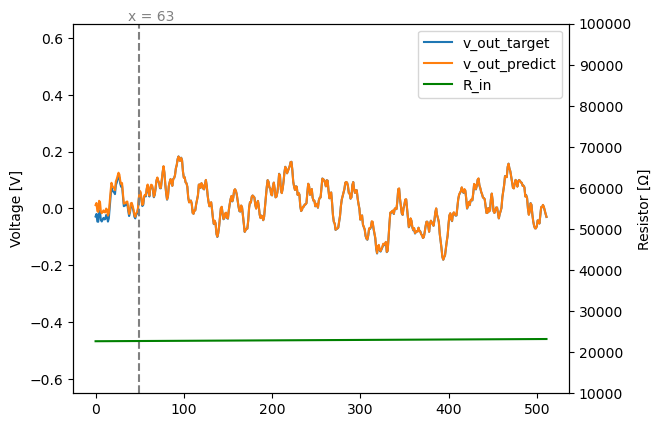

Fs: 96000.0


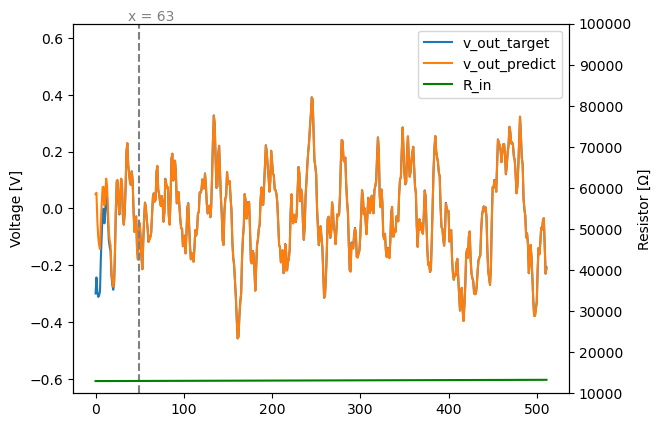

Fs: 48000.0


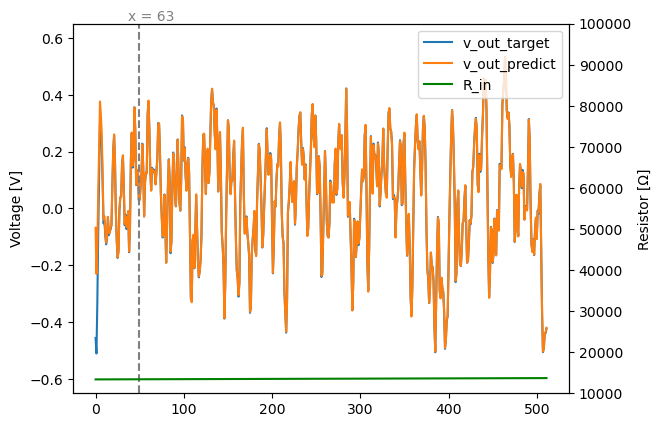

Fs: 88200.0


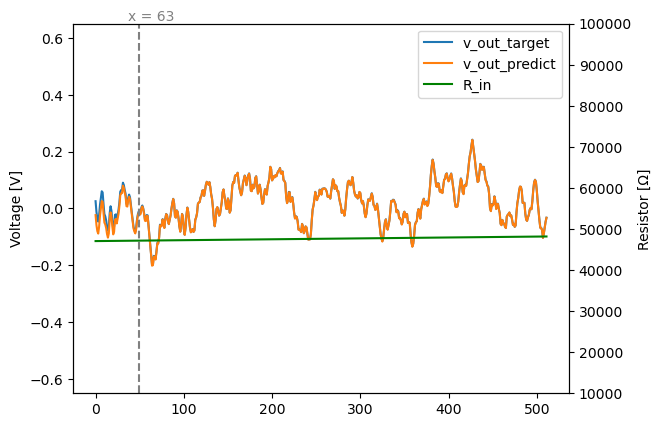

Fs: 48000.0


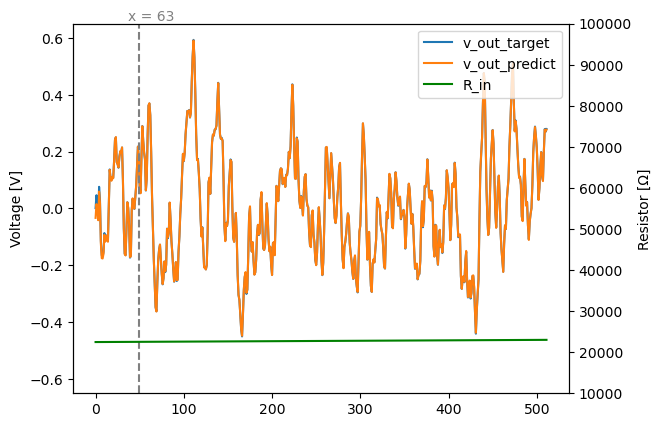

Fs: 96000.0


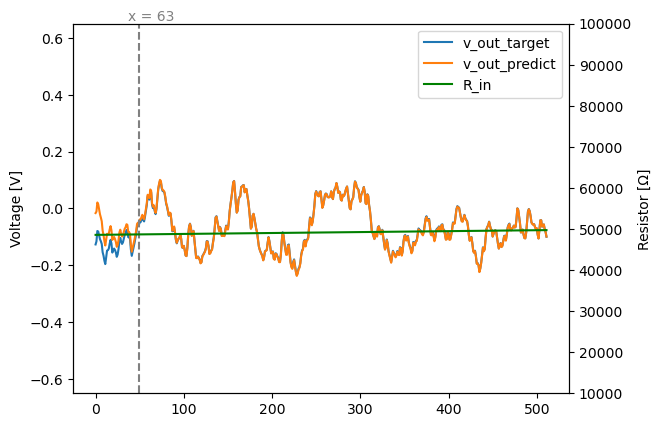

Fs: 192000.0


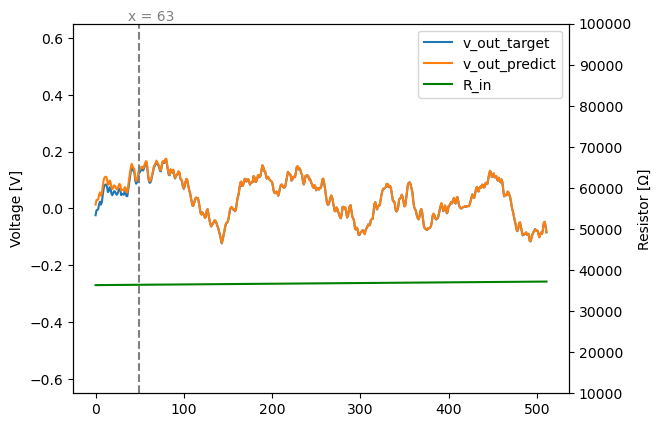

Fs: 44100.0


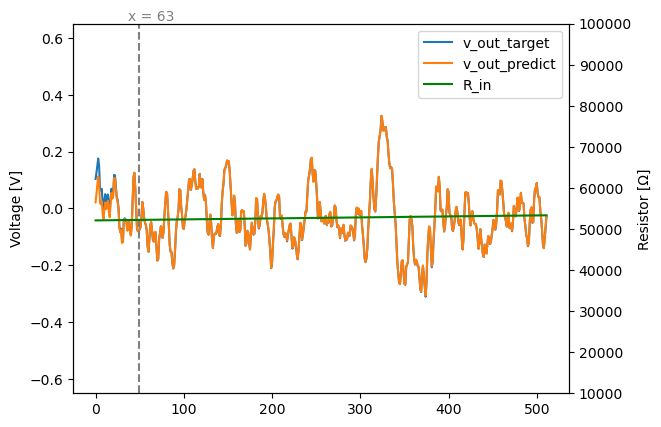

Fs: 192000.0


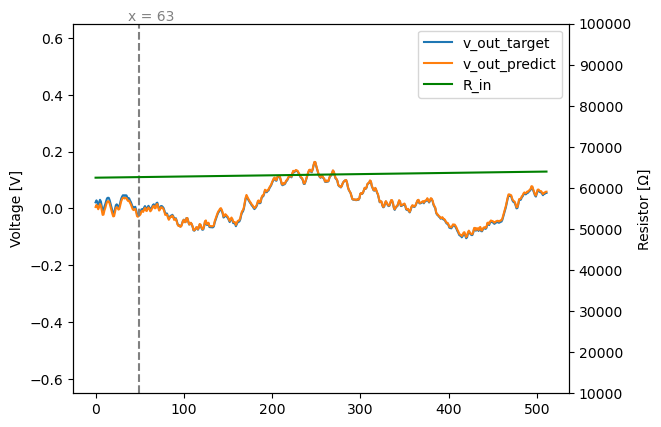

Fs: 48000.0


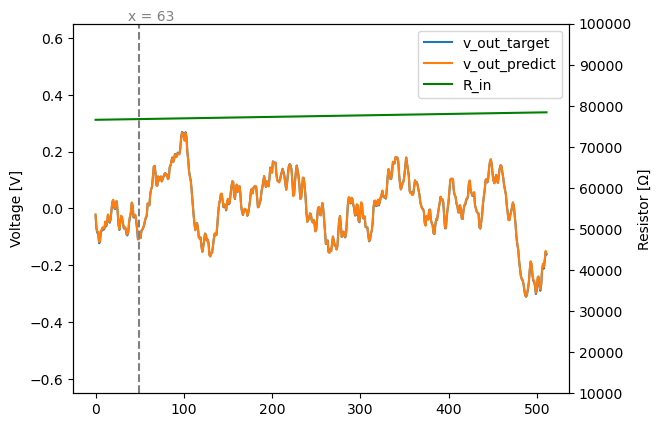

Fs: 176400.0


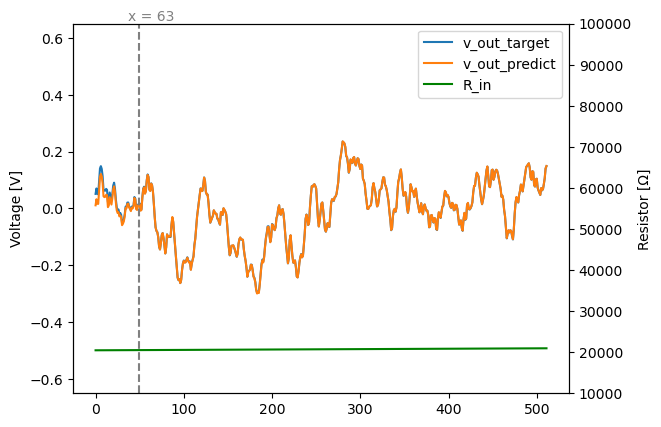

KeyboardInterrupt: 

In [7]:
real_batch_size = 512
train_dl, valid_dl = get_diodeClipper_dataloader(N=50000, Fs=Fs, num_up=num_up, num_down=num_down, r_begin=r_begin, r_end=r_end, batch_size=real_batch_size, plot=False)

for x, y in valid_dl:
    x = x.squeeze()
    v_in = x[:, 0]
    r_in = r_begin + (r_end - r_begin) * x[:, 1]
    fs_in = x[:, 2]

    pred = model(v_in, r_in, fs_in)

    v_out = y.squeeze().numpy()
    pred = pred.detach().numpy()
    r_in = r_in.numpy()

    print(f"Fs: {fs_in[0]}")

    fig, ax1 = plt.subplots()
    line1, = ax1.plot(v_out,  label='v_out_target')
    line2, = ax1.plot(pred, label='v_out_predict')
    ax1.set_ylim((-0.65, 0.65))
    ax1.set_ylabel('Voltage [V]')

    ax2 = ax1.twinx()
    line3, = ax2.plot(r_in, color='g', label='R_in')
    ax2.set_ylabel('Resistor [Ω]')
    ax2.set_ylim((10e3, 100e3))

    # 在x = 63处绘制竖直虚线
    ax1.axvline(x=skip_size-1, linestyle='dashed', color='gray')

    # 在竖直虚线上添加文字标签
    ax1.text(63, ax1.get_ylim()[1], 'x = 63', color='gray', va='bottom', ha='center')

    lines = [line1, line2, line3]
    labels = [line.get_label() for line in lines]

    ax1.legend(lines, labels, loc='upper right')

    # fig.tight_layout()
    plt.show()
    # break